The purpose of this project is to explore the number of subscribers by state by the three largest cities.    
Three largest cities are takenf rom the wikipedia page for the list of US States and their three largest cities.  


Feb 2, 2018
URL = https://simple.wikipedia.org/wiki/List_of_U.S._states%27_largest_cities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests

In [2]:
url = 'https://simple.wikipedia.org/wiki/List_of_U.S._states%27_largest_cities'
r = requests.get(url)
soup = bs(r.content,'lxml')

In [3]:
list = [state.string for state in soup.find_all('td')]
print (list)

['Alabama', 'Birmingham', 'Montgomery', 'Mobile', 'Alaska', 'Anchorage', 'Fairbanks', 'Juneau', 'Arizona', 'Phoenix', 'Tucson', 'Mesa', 'Arkansas', 'Little Rock', 'Fort Smith', 'Fayetteville', 'California', 'Los Angeles', 'San Diego', 'San Jose', 'Colorado', 'Denver', 'Colorado Springs', 'Aurora', 'Connecticut', 'Bridgeport', 'New Haven', 'Hartford', 'Delaware', 'Wilmington', 'Dover', 'Newark', 'Florida', 'Jacksonville', 'Miami', 'Tampa', 'Georgia', 'Atlanta', 'Augusta', 'Columbus', 'Hawaii', None, None, None, 'Idaho', 'Boise', 'Nampa', 'Idaho Falls', 'Illinois', 'Chicago', 'Aurora', 'Rockford', 'Indiana', 'Indianapolis', 'Fort Wayne', 'Evansville', 'Iowa', 'Des Moines', 'Cedar Rapids', 'Davenport', 'Kansas', 'Wichita', 'Overland Park', 'Kansas City', 'Kentucky', 'Louisville', 'Lexington', 'Owensboro', 'Louisiana', None, None, 'Baton Rouge', 'Maine', 'Portland', 'Lewiston', 'Bangor', 'Maryland', 'Baltimore', 'Frederick', 'Gaithersburg', 'Massachusetts', 'Boston', 'Worcester', 'Springfi

From the list you can see that after Hawaii, and Louisiana wikipedia added extra notations that are not under the same tag. This results in the city to be called None. This needs to be changed. 

In [4]:
states_city_list = np.array(list[:-20])
#list of all states followed by three of their largest cities
# also remove the last 20 results to not only include states

In [5]:
# Create a dataframe of the stats city list and name the column
df = pd.DataFrame(states_city_list, columns = ['names'])

# Add in the position for city
df['position'] = [0,1,2,3]*50

In [6]:
# Check to see if the names are placed in correctly
df.names.head(5)

0       Alabama
1    Birmingham
2    Montgomery
3        Mobile
4        Alaska
Name: names, dtype: object

In [7]:
# Separate dataframe to join later as a hierarchal dataset
states = df.names[df.position == 0]
cities = df[['names', 'position']][df.position != 0]

# Reset Index so now each state has a 1 step interval index instead factor of 4 step
states = pd.DataFrame(states.reset_index(drop = True))
cities = pd.DataFrame(cities.reset_index(drop = True))

# Create key for cities that correspond to the state index
list = []
for x in range(50):
    list += [x, x, x]

# Assign key to Cities Dataframe
cities['states'] = pd.Series(list, index=cities.index)

In [8]:
cities = cities.merge(states, left_on = 'states', right_on = np.array(states.index), how = 'left')
cities['names'] = cities.names_x
cities['statenames'] = cities.names_y

In [9]:
cities = cities[['names', 'position', 'statenames']]
cities['states'] = cities['statenames']
cities = cities[['names', 'position', 'states']]

In [10]:
# Check where beautiful soup extracted the wrong names
print(cities[cities.names.isnull()])

# The results show that the missing datapoints are States 10 and 17, which are Hawaii and Louisiana.
# They are missing positions 1, 2, 3, and 1, 2
print(states.iloc[[10, 17], :])
# So I will manually fill them out 

   names  position     states
30  None         1     Hawaii
31  None         2     Hawaii
32  None         3     Hawaii
51  None         1  Louisiana
52  None         2  Louisiana
        names
10     Hawaii
17  Louisiana


In [11]:
missing = ['Honolulu', 'Hilo', 'Kailua', 'New Orleans', 'Shreveport']
count = 0
for index in cities[cities.names.isnull()].index:
    cities.iloc[index, 0] = missing[count]
    count += 1

In [12]:
cities.iloc[[30, 31, 32, 51, 52], :]

,names,position,states
30,Honolulu,1,Hawaii
31,Hilo,2,Hawaii
32,Kailua,3,Hawaii
51,New Orleans,1,Louisiana
52,Shreveport,2,Louisiana


In [13]:
prep = cities['names'].str.lower().str.split()
templist = []
for x in range(len(prep)):
    urlname = ''.join(prep[x])
    templist.append(urlname)
cities['urlready'] = templist

In [14]:
cities.head(10)

,names,position,states,urlready
0,Birmingham,1,Alabama,birmingham
1,Montgomery,2,Alabama,montgomery
2,Mobile,3,Alabama,mobile
3,Anchorage,1,Alaska,anchorage
4,Fairbanks,2,Alaska,fairbanks
5,Juneau,3,Alaska,juneau
6,Phoenix,1,Arizona,phoenix
7,Tucson,2,Arizona,tucson
8,Mesa,3,Arizona,mesa
9,Little Rock,1,Arkansas,littlerock


In [15]:
sub_array = [0]*150

In [16]:
# https://www.dataquest.io/blog/web-scraping-beautifulsoup/
# To comply with api needs. less than 60 requests per minute and less than one request per 2 seconds. 
from time import sleep
from random import randint

num_requests = 0

for x in range(len(cities)):
    if sub_array[x] == 0:
        city = cities['urlready'][x]
        url = 'https://www.reddit.com/r/'+ city
        r = requests.get(url)
        soup = bs(r.content,'lxml')
        try:
            sub_array.append(soup.find_all("span", {"class": "number"})[0].string)
            print ('Crawled ' + cities['urlready'][x] + ' position ' + str(x))
        except:
            sub_array.append(0)
            print ('Failed crawl ' + cities['urlready'][x] + ' position ' + str(x))
        num_requests += 1
        sleep(10)

print (sub_array)

Failed crawl birmingham position 0
Failed crawl montgomery position 1
Failed crawl mobile position 2
Failed crawl anchorage position 3
Failed crawl fairbanks position 4
Failed crawl juneau position 5
Failed crawl phoenix position 6
Failed crawl tucson position 7
Failed crawl mesa position 8
Failed crawl littlerock position 9
Failed crawl fortsmith position 10
Failed crawl fayetteville position 11
Failed crawl losangeles position 12
Failed crawl sandiego position 13
Failed crawl sanjose position 14
Failed crawl denver position 15
Failed crawl coloradosprings position 16
Failed crawl aurora position 17
Failed crawl bridgeport position 18
Failed crawl newhaven position 19
Failed crawl hartford position 20
Failed crawl wilmington position 21
Failed crawl dover position 22
Crawled newark position 23
Crawled jacksonville position 24
Failed crawl miami position 25
Failed crawl tampa position 26
Failed crawl atlanta position 27
Failed crawl augusta position 28
Failed crawl columbus position 29

In [17]:
# Use API because beautiful soup is being blocked for too many unauthorized requests
import praw

reddit = praw.Reddit(client_id = '',
                    client_secret = '',
                    username = '',
                    password = '',
                    user_agent = 'subscraper')

subreddit = reddit.subreddit('Birmingham')

In [19]:
# Try again with API
sub_array = [0]*150

for x in range(len(cities)):
    if sub_array[x] == 0:
        city = cities['urlready'][x]
        subreddit = reddit.subreddit(cities['urlready'][x].title())
        try:
            sub_array[x] = subreddit.subscribers
            print ('Crawled ' + cities['urlready'][x] + ' position ' + str(x))
        except:
            print ('Failed crawl ' + cities['urlready'][x] + ' position ' + str(x))
        sleep(1.2)

cities['subscribers'] = sub_array

Crawled birmingham position 0
Crawled montgomery position 1
Crawled mobile position 2
Crawled anchorage position 3
Crawled fairbanks position 4
Crawled juneau position 5
Crawled phoenix position 6
Crawled tucson position 7
Crawled mesa position 8
Crawled littlerock position 9
Crawled fortsmith position 10
Crawled fayetteville position 11
Crawled losangeles position 12
Crawled sandiego position 13
Crawled sanjose position 14
Crawled denver position 15
Crawled coloradosprings position 16
Crawled aurora position 17
Failed crawl bridgeport position 18
Crawled newhaven position 19
Crawled hartford position 20
Crawled wilmington position 21
Crawled dover position 22
Crawled newark position 23
Crawled jacksonville position 24
Crawled miami position 25
Crawled tampa position 26
Crawled atlanta position 27
Crawled augusta position 28
Crawled columbus position 29
Crawled honolulu position 30
Crawled hilo position 31
Crawled kailua position 32
Crawled boise position 33
Crawled nampa position 34
C

In [20]:
#check the remaining areas by hand. 
cities[cities.subscribers <= 100]

,names,position,states,urlready,subscribers
8,Mesa,3,Arizona,mesa,44
18,Bridgeport,1,Connecticut,bridgeport,0
22,Dover,2,Delaware,dover,39
31,Hilo,2,Hawaii,hilo,10
34,Nampa,2,Idaho,nampa,78
44,Davenport,3,Iowa,davenport,0
55,Lewiston,2,Maine,lewiston,17
58,Frederick,2,Maryland,frederick,0
65,Warren,3,Michigan,warren,18
69,Jackson,1,Mississippi,jackson,9


In [21]:
# Correct pages that scraped the wrong pages

def c(index,newname):
    # This function takes in the index and the new name for the url
    cities.iloc[index, 3] = newname
c(8, 'mesaaz')
c(58, 'frederickmd')
c(69, 'jacksonms')
c(73, 'stlouis')
c(107, 'normanok')
c(119, 'charleston')
c(131, 'provoutah')
c(133, 'burlington')
c(142, 'huntingtonwv')

In [22]:
# Rescrape with adjusted url names
for x in range(len(cities)):
    if sub_array[x] <= 100:
        city = cities['urlready'][x]
        subreddit = reddit.subreddit(cities['urlready'][x].title())
        try:
            sub_array[x] = subreddit.subscribers
            print ('Crawled ' + cities['urlready'][x] + ' position ' + str(x))
        except:
            print ('Failed crawl ' + cities['urlready'][x] + ' position ' + str(x))
        sleep(1.2)
cities['subscribers'] = sub_array

Crawled mesaaz position 8
Failed crawl bridgeport position 18
Crawled dover position 22
Crawled hilo position 31
Crawled nampa position 34
Failed crawl davenport position 44
Crawled lewiston position 55
Crawled frederickmd position 58
Crawled warren position 65
Crawled jacksonms position 69
Failed crawl gulfport position 70
Crawled stlouis position 73
Crawled henderson position 83
Crawled paterson position 89
Crawled normanok position 107
Crawled warwick position 115
Failed crawl cranston position 116
Crawled charleston position 119
Failed crawl westvalleycity position 130
Crawled provoutah position 131
Crawled burlington position 133
Crawled rutland position 134
Crawled huntingtonwv position 142
Crawled parkersburg position 143


Text(0.5,1,'# Subreddits WRT # Subscribers')

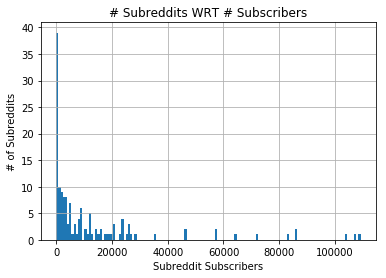

In [23]:
# Lets visualize the data set. 
# It seems like majority of these major cities do not have a lot of subscribers
cities.subscribers[cities.subscribers > 10].hist(bins=140)
plt.xlabel('Subreddit Subscribers')
plt.ylabel('# of Subreddits')
plt.title('# Subreddits WRT # Subscribers')

Text(0.5,1,'# Subreddits WRT # Subscribers')

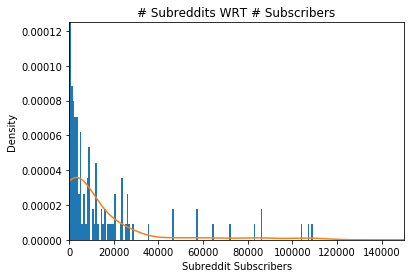

In [24]:
# It looks like the majority of subreddits have under 20000 subscribers
cities.subscribers[cities.subscribers > 0].hist(bins=140, normed = True)
cities.subscribers.plot(kind='kde')
plt.axis([0, 150000, 0, .000125])
plt.xlabel('Subreddit Subscribers')
plt.title('# Subreddits WRT # Subscribers')

In [25]:
# Look at the general statistics for the results
cities.subscribers.describe()

count       150.000000
mean      12086.053333
std       21547.250069
min           0.000000
25%         604.000000
50%        3429.000000
75%       12232.500000
max      109142.000000
Name: subscribers, dtype: float64

In [26]:
cities[cities.subscribers.duplicated(keep=False)]

,names,position,states,urlready,subscribers
17,Aurora,3,Colorado,aurora,3861
18,Bridgeport,1,Connecticut,bridgeport,0
23,Newark,3,Delaware,newark,1362
29,Columbus,3,Georgia,columbus,25962
37,Aurora,2,Illinois,aurora,3861
44,Davenport,3,Iowa,davenport,0
47,Kansas City,3,Kansas,kansascity,23953
54,Portland,1,Maine,portland,86367
62,Springfield,3,Massachusetts,springfield,604
68,Rochester,3,Minnesota,rochester,11756


In [40]:
# Initial Corrections
# c(8, 'mesaaz')
# c(58, 'frederickmd')
# c(69, 'jacksonms')
# c(73, 'stlouis')
# c(107, 'normanok')
# c(119, 'charleston')
# c(131, 'provoutah')
# c(133, 'burlington')
# c(142, 'huntingtonwv')

# Additional Corrections
c(17, 'auroraco')
c(23, 'newarkde')
c(29, 'columbusga')
c(37, 'auroraillinois')
c(54, 'portlandme')
c(68, 'rochestermn')
c(74, 'springfieldmo')
c(141, 'charlestonwv')
c(93, 'nyc')
c(81, 'vegas')


c(72, 'None')
c(18, 'None')
c(44, 'None')
c(70, 'None')
c(31, 'None')
c(44, 'None')
c(55, 'None')
c(65, 'None')
c(70, 'None')
c(83, 'None')
c(89, 'None')
c(115, 'None')
c(116, 'None')
c(119, 'None')
c(130, 'None')
c(133, 'None')
c(134, 'None')

In [41]:
# Rescrape with adjusted url names
sub_array = [0]*150

for x in range(len(cities)):
    if sub_array[x] == 0 and cities['urlready'][x] != 'None':
        city = cities['urlready'][x]
        subreddit = reddit.subreddit(cities['urlready'][x].title())
        try:
            sub_array[x] = subreddit.subscribers
            print ('Crawled ' + cities['urlready'][x] + ' position ' + str(x))
        except:
            print ('Failed crawl ' + cities['urlready'][x] + ' position ' + str(x))
        sleep(1.2)

cities['subscribers'] = sub_array

Crawled birmingham position 0
Crawled montgomery position 1
Crawled mobile position 2
Crawled anchorage position 3
Crawled fairbanks position 4
Crawled juneau position 5
Crawled phoenix position 6
Crawled tucson position 7
Crawled mesaaz position 8
Crawled littlerock position 9
Crawled fortsmith position 10
Crawled fayetteville position 11
Crawled losangeles position 12
Crawled sandiego position 13
Crawled sanjose position 14
Crawled denver position 15
Crawled coloradosprings position 16
Crawled auroraco position 17
Crawled newhaven position 19
Crawled hartford position 20
Crawled wilmington position 21
Crawled dover position 22
Crawled newarkde position 23
Crawled jacksonville position 24
Crawled miami position 25
Crawled tampa position 26
Crawled atlanta position 27
Crawled augusta position 28
Crawled columbusga position 29
Crawled honolulu position 30
Crawled kailua position 32
Crawled boise position 33
Crawled nampa position 34
Crawled idahofalls position 35
Crawled chicago positio

In [42]:
cities.to_csv('cities.csv', encoding = 'utf-8')
states.to_csv('states.csv', encoding = 'utf-8')
pd.DataFrame(sub_array).to_csv('sub_array.csv', encoding = 'utf-8')